In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import math
import os

In [2]:
# reading in an image 
image = mpimg.imread('testimage.jpg')

This image is: <class 'numpy.ndarray'> with dimensions: (662, 1159, 3)


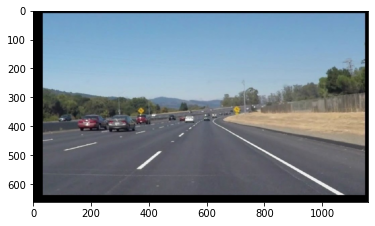

In [3]:
# printing out some stats and plotting the image
print('This image is:', type(image), 'with dimensions:', image.shape) # height, width and color channels 
plt.imshow(image)
plt.show()

In [4]:
# conver
img_name = 'testimage.jpg'
if img_name[:-3] != 'jpg':
    print('we convert the image to jpg')
    img = cv2.imread(img_name)
    cv2.imwrite(img_name[:-3] + 'jpg', img)

we convert the image to jpg


In [5]:
def region_of_interest(img, vertices):
    # Define a blank matrix that matches the image height/width.
    mask = np.zeros_like(img)
    
    # Retrieve the number of color channels of the image
#     channel_count = img.shape[2]
    
    # Create a match color with the same color channel counts
    match_mask_color = 255 # (255,) * channel_count
    
    # Fill inside the polycon
    cv2.fillPoly(mask, vertices, match_mask_color)
    
    # Returning the image only where mask pixels match
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

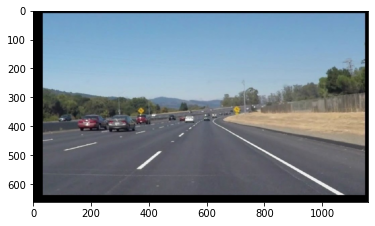

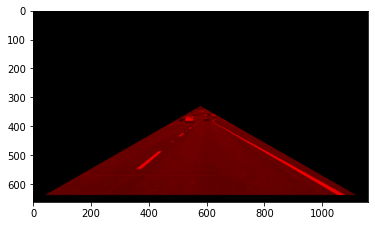

In [6]:
height =image.shape[0]
width =image.shape[1]

region_of_interest_vertices = [
    (0, height),
    (width / 2, height / 2),
    (width, height),
]

plt.figure()
plt.imshow(image)
plt.show()

cropped_image = region_of_interest(img, np.array([region_of_interest_vertices], np.int32),)

plt.figure()
plt.imshow(cropped_image)

plt.show()

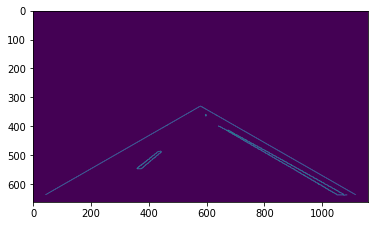

In [7]:
# Convert to grayscale here 
gray_image = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2GRAY)

# call canny edge detection 
canny_image  = cv2.Canny(gray_image, 100, 200)

cropped_image = region_of_interest(image, np.array([region_of_interest_vertices], np.int32),)

plt.figure()
plt.imshow(canny_image)
plt.show()

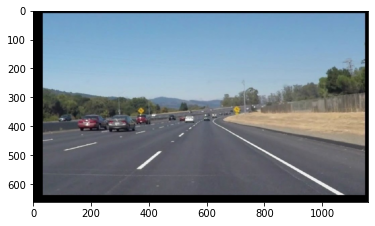

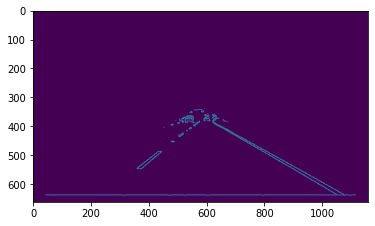

In [8]:
# Convert the whole image to grasycale and detect our area of interest

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    match_mask_color = 255 # <-- This line altered for grayscale.
    
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


# image = mpimg.imread('solidWhiteCurve.jpg')
plt.figure()
plt.imshow(image)
plt.show()

gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
cannyed_image = cv2.Canny(gray_image, 100, 200)

# Moved the cropping operation to the end of the pipeline.
cropped_image = region_of_interest(
    cannyed_image,
    np.array([region_of_interest_vertices], np.int32)
)

plt.figure()
plt.imshow(cropped_image)
plt.show()

In [10]:
# Lets detect lines in the grayscale (x1, y1, x2, y2)

lines = cv2.HoughLinesP(
cropped_image,
    rho=6,
    theta=np.pi / 60,
    threshold=160,
    lines=np.array([]),
    minLineLength=40,
    maxLineGap=25
)
# print(lines)

In [11]:
def draw_lane_lines(lines):
    img = np.zeros((perspective_max_y, perspective_max_x, 3), dtype="uint8")
    points = [[],[]]
    for line_idx in range(2):
        line = lines[line_idx]
        for i in range(31):
            y = int(perspective_max_y * i / 30)
            x = int(line[0] * y**2 + line[1] * y + line[2])
            points[line_idx].append((x,y))
    points[1].reverse()
    cv2.fillPoly(img, np.int_([points[0] + points[1]]), (0,255,0))
    return img

In [12]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    # If there are no lines to draw, exit
    if lines is None:
        print('no line to draw')
        return
    
    # Make a copy of the original image.
    img = np.copy(img)
    
    # Create a blank image that matches the original in size
    line_img = np.zeros(
        (
            img.shape[0],
            img.shape[1],
            3
        ),
        dtype=np.uint8,
    )
    
    # Loop over all lines and draw them on the blank image.
    for line in lines:
        
#         print('line',line)
        for x1, y1, x2, y2 in line:
            cv2.line(line_img, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)
            
    # Merge the image with lines onto the original
    img = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0)
#     cv2.fillPoly(img, lines, color)
    # Return the modified image.
    return img

type:<class 'numpy.ndarray'>


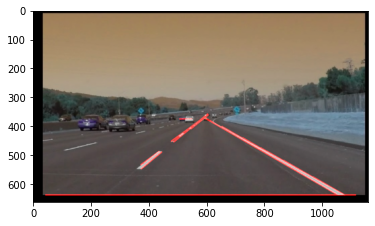

In [13]:
line_image = draw_lines(img, lines) # Add this call
print(f"type:{line_image.__class__}")
plt.figure()
plt.imshow(line_image)
plt.show()

In [14]:
def pipeline(image):
    height = image.shape[0]
    width = image.shape[1]
    region_of_interest_vertices = [
        (0, height),
        (width / 2, height / 2),
        (width, height),
    ]
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    cannyed_image = cv2.Canny(gray_image, 50, 70)
    cropped_image = region_of_interest(
            cannyed_image,
            np.array(
                [region_of_interest_vertices],
                np.int32
            ),
        )

 
    lines = cv2.HoughLinesP(
        cropped_image,
        rho=6,
        theta=np.pi / 60,
        threshold=160,
        lines=np.array([]),
        minLineLength=40,
        maxLineGap=25
    )
 
    left_line_x = []
    left_line_y = []
    right_line_x = []
    right_line_y = []
 
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            if math.fabs(slope) < 0.5:
                continue
            if slope <= 0:
                left_line_x.extend([x1, x2])
                left_line_y.extend([y1, y2])
            else:
                right_line_x.extend([x1, x2])
                right_line_y.extend([y1, y2])
    min_y = int(image.shape[0] * (3 / 5))
    max_y = int(image.shape[0])
    poly_left = np.poly1d(np.polyfit(
        left_line_y,
        left_line_x,
        deg=1
    ))
 
    left_x_start = int(poly_left(max_y))
    left_x_end = int(poly_left(min_y))
 
    poly_right = np.poly1d(np.polyfit(
        right_line_y,
        right_line_x,
       deg=1
    ))
 
    right_x_start = int(poly_right(max_y))
    right_x_end = int(poly_right(min_y))
    line_image = draw_lines(
        image,
        [[
            [left_x_start, max_y, left_x_end, min_y],
            [right_x_start, max_y, right_x_end, min_y],
        ]],
        thickness=5,
    )
#     print(f"type:{line_image.__class__}")
    return line_image